In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2  
from scipy.interpolate import griddata

In [2]:
def display_image(im, title='Image'):
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

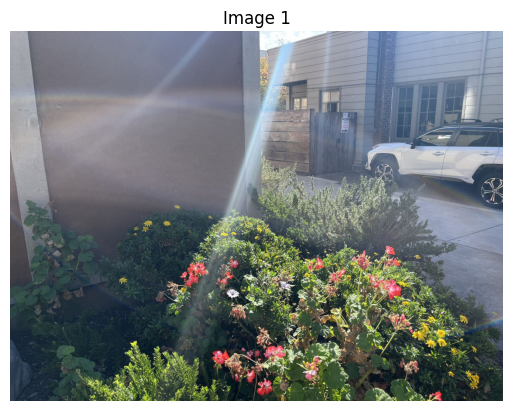

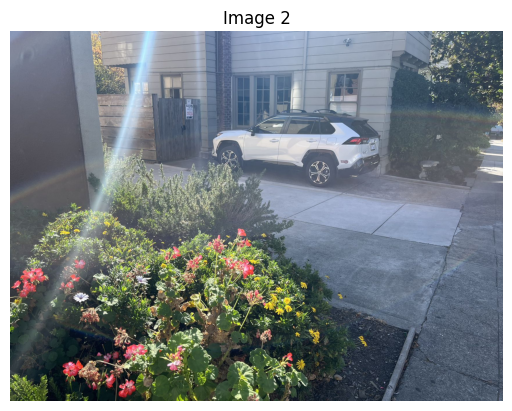

In [3]:
im1 = cv2.imread('f1.jpg')  
im2 = cv2.imread('f2.jpg')

display_image(im1, 'Image 1')
display_image(im2, 'Image 2')

In [3]:
def computeH(im1_pts, im2_pts):
    n = im1_pts.shape[0]
    
    A = []
    for i in range(n):
        x1, y1 = im1_pts[i, 0], im1_pts[i, 1]  # Points in image 1
        x2, y2 = im2_pts[i, 0], im2_pts[i, 1]  # Points in image 2
        
        A.append([-x1, -y1, -1, 0, 0, 0, x2*x1, x2*y1, x2])
        A.append([0, 0, 0, -x1, -y1, -1, y2*x1, y2*y1, y2])
    
    A = np.array(A)
    
    U, S, Vh = np.linalg.svd(A)
    H = Vh[-1].reshape(3, 3)
    
    H = H / H[2, 2]
    
    return H

def select_points(image, num_points=4):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Select {num_points} points")
    points = plt.ginput(num_points, timeout=0)  
    plt.close()
    
    points = np.array(points)
    return points

In [5]:
%matplotlib tk

print("Select points from Image 1")
im1_pts = select_points(im1, num_points=4)  

print("Select points from Image 2")
im2_pts = select_points(im2, num_points=4)

print("Image 1 points:\n", im1_pts)
print("Image 2 points:\n", im2_pts)

H = computeH(im1_pts, im2_pts)
print("Homography matrix:\n", H)

%matplotlib inline

Select points from Image 1
Select points from Image 2
Image 1 points:
 [[1196.38340009  275.58722741]
 [1318.99132176  746.65976858]
 [1573.24143302  989.29439252]
 [1672.61838006  551.7777036 ]]
Image 2 points:
 [[ 655.61793502  232.99710725]
 [ 809.20048954  687.2917223 ]
 [1023.44170004  867.97708055]
 [1064.7412105   485.95660881]]
Homography matrix:
 [[ 1.93307233e+00  2.47684680e-01 -1.28497322e+03]
 [ 1.69592828e-01  1.74279298e+00 -2.93693720e+02]
 [ 5.34908466e-04  1.15103250e-04  1.00000000e+00]]


In [4]:
def compute_output_size(H, im):
    h, w = im.shape[:2]
    corners = np.array([[0, 0, 1],    # Top-left
                        [w, 0, 1],    # Top-right
                        [0, h, 1],    # Bottom-left
                        [w, h, 1]])   # Bottom-right
    
    transformed_corners = H @ corners.T
    transformed_corners /= transformed_corners[2, :]  # Normalize by the third coordinate
    
    x_transformed = transformed_corners[0, :]
    y_transformed = transformed_corners[1, :]
    
    min_x, max_x = np.min(x_transformed), np.max(x_transformed)
    min_y, max_y = np.min(y_transformed), np.max(y_transformed)
    
    output_width = int(np.ceil(max_x - min_x))
    output_height = int(np.ceil(max_y - min_y))
    
    return output_width, output_height, min_x, min_y

def warpImage(im, H):
    output_width, output_height, min_x, min_y = compute_output_size(H, im)
    
    y_grid, x_grid = np.mgrid[0:output_height, 0:output_width]
    
    x_grid = x_grid + min_x
    y_grid = y_grid + min_y
    
    grid = np.vstack((x_grid.ravel(), y_grid.ravel(), np.ones_like(x_grid.ravel())))
    
    H_inv = np.linalg.inv(H)
    input_grid = H_inv @ grid
    input_grid /= input_grid[2, :] 
    
    x_in = input_grid[0, :].reshape(output_height, output_width)
    y_in = input_grid[1, :].reshape(output_height, output_width)
    
    warped_im = griddata(
        (np.indices(im.shape[:2])[1].ravel(), np.indices(im.shape[:2])[0].ravel()),
        im.reshape(-1, 3), (x_in, y_in), method='linear', fill_value=0
    )
    
    return warped_im.astype(np.uint8)


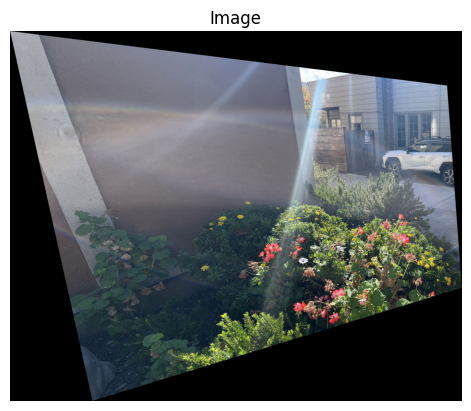

In [7]:
im1_warped = warpImage(im1, H)
display_image(im1_warped)

In [5]:
def blend_images(im1_warped, im2, H, alpha=0.5):
    h1, w1 = im1_warped.shape[:2]
    h2, w2 = im2.shape[:2]

    corners = np.array([[0, 0, 1],    # Top-left
                        [w2, 0, 1],    # Top-right
                        [0, h2, 1],    # Bottom-left
                        [w2, h2, 1]])   # Bottom-right
    transformed_corners = H @ corners.T
    transformed_corners /= transformed_corners[2, :]  # Normalize by the third coordinate

    min_x = -int(transformed_corners[0, :].min())
    min_y = -int(transformed_corners[1, :].min())

    canvas_width = max(w1, min_x + w2)
    canvas_height = max(h1, min_y + h2)

    # Initialize
    final_canvas = np.zeros((canvas_height, canvas_width, 3), dtype=np.float32)

    mask = np.zeros((canvas_height, canvas_width, 3), dtype=np.float32)
    overlap_start_y = max(0, min_y)
    overlap_end_y = min(h1, min_y + h2)
    overlap_start_x = max(0, min_x)
    overlap_end_x = min(w1, min_x + w2)

    mask[overlap_start_y:overlap_end_y, overlap_start_x:overlap_end_x] = np.linspace(1, 0, overlap_end_x - overlap_start_x)[:, None]

    # Apply Laplacian blending in the overlapping region
    im1_normalized = im1_warped / 255.0
    im2_normalized = im2 / 255.0

    # Fill the final canvas with im1 and im2
    final_canvas[:h1, :w1] = im1_normalized
    final_canvas[min_y:min_y + h2, min_x:min_x + w2] = im2_normalized

    # Apply the blending mask in the overlap area to smooth out transitions
    final_canvas[overlap_start_y:overlap_end_y, overlap_start_x:overlap_end_x] = (
        mask[overlap_start_y:overlap_end_y, overlap_start_x:overlap_end_x] * im1_normalized[overlap_start_y:overlap_end_y, overlap_start_x:overlap_end_x] +
        (1 - mask[overlap_start_y:overlap_end_y, overlap_start_x:overlap_end_x]) * im2_normalized[overlap_start_y - min_y:overlap_end_y - min_y, overlap_start_x - min_x:overlap_end_x - min_x]
    )

    return (final_canvas * 255).astype(np.uint8)


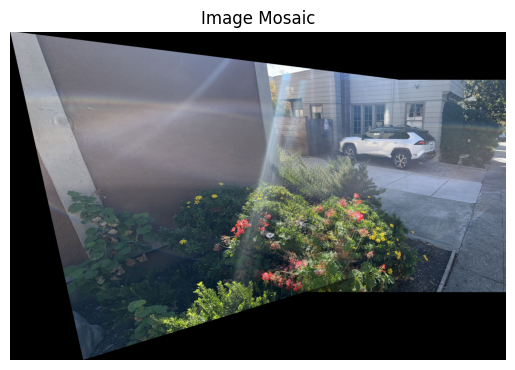

In [9]:
mosaic = blend_images(im1_warped, im2, H)
display_image(mosaic, 'Image Mosaic')

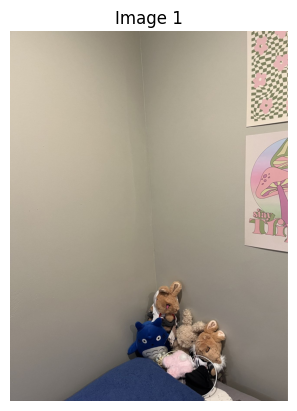

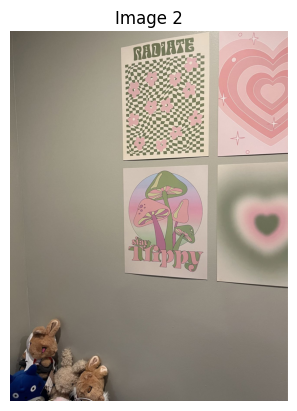

Select points from Image 1
Select points from Image 2
Image 1 points:
 [[1153.20884412  223.68125177]
 [1073.83432455  989.81791884]
 [ 777.04264272 1146.84142493]
 [ 928.8895497  1329.74792653]]
Image 2 points:
 [[ 569.97867864  406.58775337]
 [ 525.11481976 1115.78183032]
 [ 209.34227455 1324.57132743]
 [ 390.52324311 1488.49696565]]
Homography matrix:
 [[ 1.99926064e+00  2.61883779e-02 -1.27165782e+03]
 [ 6.48052076e-01  1.59828441e+00 -3.63141145e+02]
 [ 7.27475280e-04 -6.57785111e-05  1.00000000e+00]]


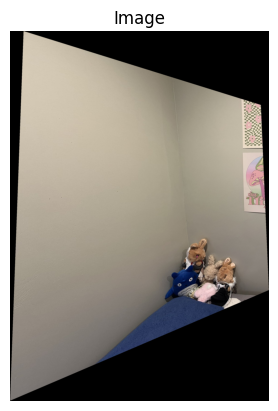

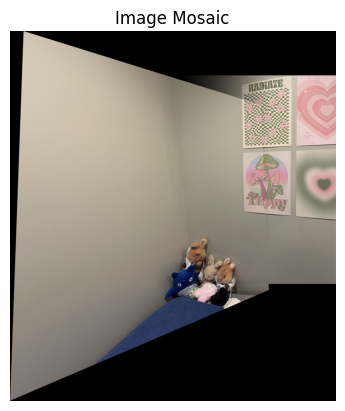

In [10]:
# Complete workflow - 2
im1 = cv2.imread('b1.jpg')  
im2 = cv2.imread('b2.jpg')

display_image(im1, 'Image 1')
display_image(im2, 'Image 2')

%matplotlib tk

print("Select points from Image 1")
im1_pts = select_points(im1, num_points=4)  

print("Select points from Image 2")
im2_pts = select_points(im2, num_points=4)

%matplotlib inline

print("Image 1 points:\n", im1_pts)
print("Image 2 points:\n", im2_pts)

H = computeH(im1_pts, im2_pts)
print("Homography matrix:\n", H)

im1_warped = warpImage(im1, H)
display_image(im1_warped)

mosaic = blend_images(im1_warped, im2, H)
display_image(mosaic, 'Image Mosaic')

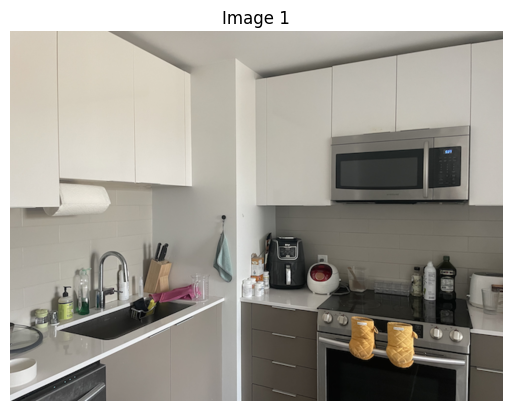

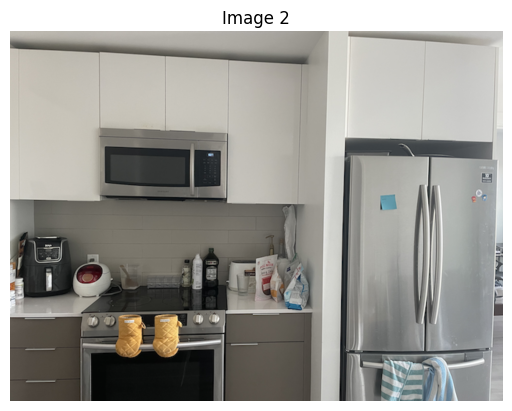

Select points from Image 1
Select points from Image 2
Image 1 points:
 [[ 788.74723874  564.24426508]
 [ 839.72429907  753.87892948]
 [1254.67757009  811.99277825]
 [1257.73619371  254.30373832]]
Image 2 points:
 [[154.59260833 561.18564146]
 [197.413339   768.15250637]
 [589.93670348 756.9375531 ]
 [592.9953271  273.67502124]]
Homography matrix:
 [[ 1.82187819e+00 -1.79151795e-01 -1.11149115e+03]
 [ 3.24407117e-01  1.43024219e+00 -2.48197907e+02]
 [ 7.86254947e-04 -2.98520500e-04  1.00000000e+00]]


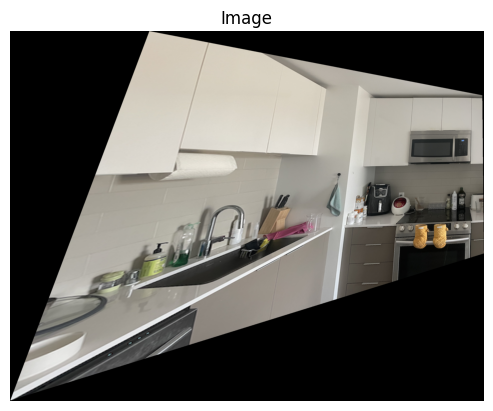

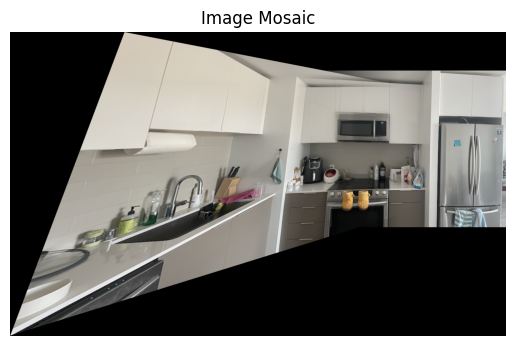

In [12]:
# Complete workflow - 3
im1 = cv2.imread('k1.png')  
im2 = cv2.imread('k2.png')

display_image(im1, 'Image 1')
display_image(im2, 'Image 2')

%matplotlib tk

print("Select points from Image 1")
im1_pts = select_points(im1, num_points=4)  

print("Select points from Image 2")
im2_pts = select_points(im2, num_points=4)

%matplotlib inline

print("Image 1 points:\n", im1_pts)
print("Image 2 points:\n", im2_pts)

H = computeH(im1_pts, im2_pts)
print("Homography matrix:\n", H)

im1_warped = warpImage(im1, H)
display_image(im1_warped)

mosaic = blend_images(im1_warped, im2, H)
display_image(mosaic, 'Image Mosaic')

Select points from Image 1


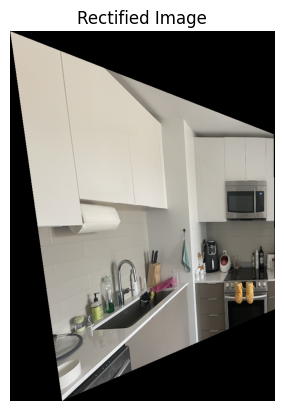

In [6]:
# rectifying 
%matplotlib tk

im1 = cv2.imread('k1.png')  

print("Select points from Image 1")
im1_pts = select_points(im1, num_points=4)  

%matplotlib inline

im2_pts = np.array([[0, 0], [0, 1], [1, 0], [1, 1]]) * 100
H_rectify = computeH(im1_pts, im2_pts)

im_rectified = warpImage(im1, H_rectify)  # Adjust output size
display_image(im_rectified, 'Rectified Image')
